In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
# License: MIT

# Combined plots of HadISST SST analysis results

## Packages

In [3]:
%matplotlib inline

import itertools
import os
import time

import cartopy.crs as ccrs
import cmocean
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np
import xarray as xr

from cartopy.util import add_cyclic_point
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import MDS, TSNE

## Analysis parameters

In [4]:
TIME_NAME = 'time'
LAT_NAME = 'latitude'
LON_NAME = 'longitude'
ANOMALY_NAME = 'sst_anom'
STANDARDIZED_ANOMALY_NAME = 'sst_std_anom'

# First and last years to retain for analysis
START_YEAR = 1870
END_YEAR = 2018

# First and last years of climatology base period
BASE_PERIOD_START_YEAR = 1981
BASE_PERIOD_END_YEAR = 2010

# Order of trend removed from anomalies
ANOMALY_TREND_ORDER = 1

# Zonal extents of analysis region
MIN_LATITUDE = -45.5
MAX_LATITUDE = 45.5

# Weighting used for EOFs
LAT_WEIGHTS = 'scos'
RESTRICT_TO_CLIMATOLOGY_BASE_PERIOD = False

# Number of random restarts to use
N_INIT = 100

# If cross-validation is used, number of cross-validation folds
N_FOLDS = 10

# Relaxation parameter for dictionary in archetypal analysis
DELTA = 0

# Reference distribution used for gap statistic
REFERENCE = 'pca'

## File paths

In [5]:
def get_kmeans_output_filename(input_file, lat_weights, n_components, n_init, gap_reference=REFERENCE, cross_validate=False, n_folds=N_FOLDS):
    """Get k-means output file corresponding to a given input file."""
    
    basename, ext = os.path.splitext(input_file)
    suffix = 'kmeans.{}.k{:d}.n_init{:d}.{}_gap'.format(lat_weights, n_components, n_init, gap_reference)
    if cross_validate:
        suffix = '.'.join([suffix, 'n_folds{:d}'.format(n_folds)])
        
    return '.'.join([basename, suffix]) + ext

In [6]:
def get_aa_output_filename(input_file, lat_weights, n_components, delta, n_init, cross_validate=False, n_folds=N_FOLDS):
    """Get AA output file corresponding to a given input file."""
    
    basename, ext = os.path.splitext(input_file)
    suffix = 'aa.{}.k{:d}.delta{:5.3e}.n_init{:d}'.format(lat_weights, n_components, delta, n_init)
    if cross_validate:
        suffix = '.'.join([suffix, 'n_folds{:d}'.format(n_folds)])
        
    return '.'.join([basename, suffix]) + ext

In [7]:
def get_gpnh_output_filename(input_file, lat_weights, n_components, lambda_W, n_init, cross_validate=False, n_folds=N_FOLDS):
    """Get GPNH output file corresponding to a given input file."""
    
    basename, ext = os.path.splitext(input_file)
    suffix = 'gpnh.{}.k{:d}.lambda_W{:5.3e}.n_init{:d}'.format(lat_weights, n_components, lambda_W, n_init)
    if cross_validate:
        suffix = '.'.join([suffix, 'n_folds{:d}'.format(n_folds)])
        
    return '.'.join([basename, suffix]) + ext

In [8]:
PROJECT_DIR = os.path.join(os.getenv('HOME'), 'projects', 'convex-dim-red-expts')
BIN_DIR = os.path.join(PROJECT_DIR, 'bin')
BASE_RESULTS_DIR = os.path.join(PROJECT_DIR, 'results')
RESULTS_DIR = os.path.join(BASE_RESULTS_DIR, 'hadisst', 'nc')
CSV_DIR = os.path.join(BASE_RESULTS_DIR, 'hadisst', 'csv')
PLOTS_DIR = os.path.join(BASE_RESULTS_DIR, 'hadisst', 'plt')

if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

SST_ANOM_INPUT_FILE = os.path.join(RESULTS_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.nc'.format(
    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER))
SST_STD_ANOM_INPUT_FILE = os.path.join(RESULTS_DIR, 'HadISST_sst.std_anom.{:d}_{:d}.trend_order{:d}.nc'.format(
    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER))

if not os.path.exists(SST_ANOM_INPUT_FILE):
    raise RuntimeError("Input data file '%s' does not exist" % SST_ANOM_INPUT_FILE)
    
if not os.path.exists(SST_STD_ANOM_INPUT_FILE):
    raise RuntimeError("Input data file '%s' does not exist" % SST_STD_ANOM_INPUT_FILE)

## Helper functions

In [9]:
def to_1d_array(da):
    """Convert DataArray to flat array."""

    flat_data = np.ravel(da.values)

    missing_features = np.isnan(flat_data)

    return flat_data[np.logical_not(missing_features)]


def pattern_correlation(state, eof):
    """Calculate pattern correlation between state and EOF."""

    flat_state = to_1d_array(state)
    flat_eof = to_1d_array(eof)

    data = np.vstack([flat_state, flat_eof])

    r = np.corrcoef(data, rowvar=True)

    return r[0, 1]


def sort_states(ds, eofs_reference_file, variable_name='dictionary'):
    """Sort states according to pattern correlation with EOFs."""

    n_components = ds.sizes['component']

    sort_order = []
    with xr.open_dataset(eofs_reference_file) as eofs_ds:

        n_eofs = eofs_ds.sizes['component']

        for i in range(n_eofs):
            correlations = np.empty((n_components,))

            for k in range(n_components):
                correlations[k] = pattern_correlation(
                    ds[variable_name].sel(component=k),
                    eofs_ds['EOFs'].sel(component=i))

            ordering = np.argsort(-np.abs(correlations))
            for k in range(n_components):
                if ordering[k] not in sort_order:
                    sort_order.append(ordering[k])
                    break

            if np.size(sort_order) == n_components:
                break

    assert len(sort_order) <= n_components
    assert np.size(np.unique(sort_order)) == np.size(sort_order)

    if len(sort_order) < n_components:
        unassigned = [i for i in range(n_components) if i not in sort_order]
        sort_order += unassigned

    assert len(sort_order) == n_components
    assert np.size(np.unique(sort_order)) == np.size(sort_order)

    sorted_ds = xr.zeros_like(ds)
    for i in range(n_components):
        sorted_ds = xr.where(sorted_ds['component'] == i,
                             ds.sel(component=sort_order[i]), sorted_ds)

    for a in ds.attrs:
        sorted_ds.attrs[a] = ds.attrs[a]

    return sorted_ds

In [10]:
def get_latitude_weights(da, lat_weights='scos', lat_name=LAT_NAME):
    """Get latitude weights."""

    if lat_weights == 'cos':
        return np.cos(np.deg2rad(da[lat_name])).clip(0., 1.)

    if lat_weights == 'scos':
        return np.cos(np.deg2rad(da[lat_name])).clip(0., 1.) ** 0.5

    if lat_weights == 'none':
        return xr.ones_like(da[lat_name])

    raise ValueError("Invalid weights descriptor '%r'" % lat_weights)


def weight_and_flatten_data(da, weights=None, sample_dim=TIME_NAME):
    """Apply weighting to data and convert to 2D array."""

    feature_dims = [d for d in da.dims if d != sample_dim]
    original_shape = [da.sizes[d] for d in da.dims if d != sample_dim]

    if weights is not None:
        weighted_da = (weights * da).transpose(*da.dims)
    else:
        weighted_da = da

    if weighted_da.get_axis_num(sample_dim) != 0:
        weighted_da = weighted_da.transpose(*([sample_dim] + feature_dims))

    n_samples = weighted_da.sizes[sample_dim]
    n_features = np.product(original_shape)

    flat_data = weighted_da.data.reshape(n_samples, n_features)

    return flat_data

In [11]:
def run_mds(arrays, n_components=2, metric=True,
            n_init=4, max_iter=300, verbose=0, eps=0.001, n_jobs=None,
            random_state=None, lat_name=LAT_NAME, sample_dim=TIME_NAME):
    """Run MDS on given data."""

    variable_names = [v for v in arrays]
    n_variables = len(variable_names)

    # Convert input arrays to plain 2D arrays
    flat_arrays = [weight_and_flatten_data(arrays[variable_names[i]], sample_dim=sample_dim)
                   for i in range(n_variables)]
    
    n_samples = [a.shape[0] for a in flat_arrays]
    total_input_rows = np.sum(n_samples)

    n_features = None
    for a in flat_arrays:
        if n_features is None:
            n_features = a.shape[1]
        else:
            if a.shape[1] != n_features:
                raise ValueError('All arrays do not have same number of feature dimensions')

    flat_data = np.vstack(flat_arrays)

    # Remove any features/columns with missing data
    missing_features = np.any(np.isnan(flat_data), axis=0)
    valid_data = flat_data[:, np.logical_not(missing_features)]
    
    # Add the origin in initial space for reference
    valid_data = np.vstack([valid_data, np.zeros(valid_data.shape[1])])

    mds = MDS(n_components=n_components, metric=metric, n_init=n_init,
              max_iter=max_iter, verbose=verbose, eps=eps, n_jobs=n_jobs,
              random_state=random_state, dissimilarity='euclidean').fit(valid_data)
    
    results = {v: None for v in arrays}
    
    row_start = 0
    for i in range(n_variables):
        
        v = variable_names[i]
        n_rows = n_samples[i]

        embedding_da = xr.DataArray(
            mds.embedding_[row_start:row_start + n_rows],
            coords={sample_dim: arrays[v][sample_dim], 'mds_coord': np.arange(n_components)},
            dims=[sample_dim, 'mds_coord'])
        
        origin_da = xr.DataArray(
            mds.embedding_[-1], coords={'mds_coord': np.arange(n_components)},
            dims=['mds_coord'])
        
        results[v] = xr.Dataset({'embedding': embedding_da, 'origin': origin_da})
        results[v].attrs['stress'] = '{:16.8e}'.format(mds.stress_)
        
        row_start += n_rows
        
    return results

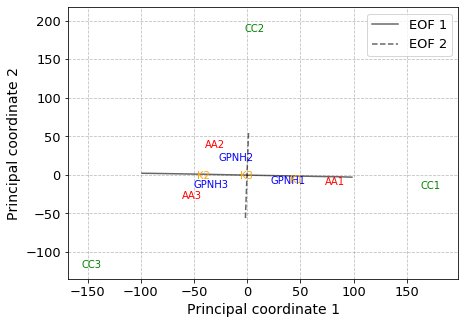

In [53]:
n_components = 3
lambda_W = 1e3

aa_output_file = get_aa_output_filename(SST_ANOM_INPUT_FILE, LAT_WEIGHTS, n_components, DELTA, N_INIT)
kmeans_output_file = get_kmeans_output_filename(SST_ANOM_INPUT_FILE, LAT_WEIGHTS, n_components, N_INIT, REFERENCE)
gpnh_no_reg_output_file = get_gpnh_output_filename(SST_ANOM_INPUT_FILE, LAT_WEIGHTS, n_components, 0, N_INIT)
gpnh_reg_output_file = get_gpnh_output_filename(SST_ANOM_INPUT_FILE, LAT_WEIGHTS, n_components, lambda_W, N_INIT)

aa_ds = xr.open_dataset(aa_output_file)
gpnh_no_reg_ds = xr.open_dataset(gpnh_no_reg_output_file)
gpnh_reg_ds = xr.open_dataset(gpnh_reg_output_file)
kmeans_ds = xr.open_dataset(kmeans_output_file)

eofs_reference_file = os.path.join(RESULTS_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.pca.{}.k{:d}.nc'.format(
        BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS, n_components))

eofs_ds = xr.open_dataset(eofs_reference_file)

n_samples = eofs_ds.sizes[TIME_NAME]
n_test_points = 100

leading_max_magnitude = 3 * eofs_ds['singular_values'].sel(component=0) / (n_samples - 1) ** 0.5
leading_test_magnitudes = np.linspace(-leading_max_magnitude, leading_max_magnitude, n_test_points)

leading_test_vectors = np.array([leading_test_magnitudes[i] * eofs_ds['EOFs'].sel(component=0).values
                                 for i in range(np.size(test_magnitudes))])

leading_test_vectors_da = xr.DataArray(
    leading_test_vectors,
    coords={'component': np.arange(100),
            LAT_NAME: aa_ds[LAT_NAME].values,
            LON_NAME: aa_ds[LON_NAME].values},
    dims=['component', LAT_NAME, LON_NAME])

subleading_max_magnitude = 3 * eofs_ds['singular_values'].sel(component=1) / (n_samples - 1) ** 0.5
subleading_test_magnitudes = np.linspace(-subleading_max_magnitude, subleading_max_magnitude, n_test_points)

subleading_test_vectors = np.array([subleading_test_magnitudes[i] * eofs_ds['EOFs'].sel(component=1).values
                                    for i in range(np.size(test_magnitudes))])

subleading_test_vectors_da = xr.DataArray(
    subleading_test_vectors,
    coords={'component': np.arange(100),
            LAT_NAME: aa_ds[LAT_NAME].values,
            LON_NAME: aa_ds[LON_NAME].values},
    dims=['component', LAT_NAME, LON_NAME])

eofs_ds.close()

aa_ds = sort_states(aa_ds, eofs_reference_file, variable_name='archetypes')
gpnh_no_reg_ds = sort_states(gpnh_no_reg_ds, eofs_reference_file, variable_name='dictionary')
gpnh_reg_ds = sort_states(gpnh_reg_ds, eofs_reference_file, variable_name='dictionary')
kmeans_ds = sort_states(kmeans_ds, eofs_reference_file, variable_name='dictionary')

mds_2d_scos_results = run_mds({'archetypes': aa_ds['archetypes'], 'kmeans': kmeans_ds['dictionary'],
                               'gpnh_no_reg': gpnh_no_reg_ds['dictionary'], 'gpnh_reg': gpnh_reg_ds['dictionary'],
                               'leading_principal_vector': leading_test_vectors_da,
                               'subleading_principal_vector': subleading_test_vectors_da},
                              n_components=2, random_state=0, sample_dim='component')

fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

x_min = None
x_max = None
y_min = None
y_max = None

archetype_x_coords = mds_2d_scos_results['archetypes']['embedding'].sel(mds_coord=0).values
archetype_y_coords = mds_2d_scos_results['archetypes']['embedding'].sel(mds_coord=1).values

if x_min is None or np.min(archetype_x_coords) < x_min:
    x_min = np.min(archetype_x_coords)

if x_max is None or np.max(archetype_x_coords) > x_max:
    x_max = np.max(archetype_x_coords)

if y_min is None or np.min(archetype_y_coords) < y_min:
    y_min = np.min(archetype_y_coords)

if y_max is None or np.max(archetype_y_coords) > y_max:
    y_max = np.max(archetype_y_coords)

# ax.plot(mds_2d_scos_results['archetypes']['embedding'].sel(mds_coord=0),
#         mds_2d_scos_results['archetypes']['embedding'].sel(mds_coord=1), marker='none', label='Archetypes')

for i, coords in enumerate(zip(archetype_x_coords, archetype_y_coords)):
    ax.text(coords[0], coords[1], 'AA{:d}'.format(i + 1),
            color='red', fontsize=10, ha='center', va='center')

gpnh_no_reg_x_coords = mds_2d_scos_results['gpnh_no_reg']['embedding'].sel(mds_coord=0).values
gpnh_no_reg_y_coords = mds_2d_scos_results['gpnh_no_reg']['embedding'].sel(mds_coord=1).values

if x_min is None or np.min(gpnh_no_reg_x_coords) < x_min:
    x_min = np.min(gpnh_no_reg_x_coords)

if x_max is None or np.max(gpnh_no_reg_x_coords) > x_max:
    x_max = np.max(gpnh_no_reg_x_coords)

if y_min is None or np.min(gpnh_no_reg_y_coords) < y_min:
    y_min = np.min(gpnh_no_reg_y_coords)

if y_max is None or np.max(gpnh_no_reg_y_coords) > y_max:
    y_max = np.max(gpnh_no_reg_y_coords)

# # ax.plot(mds_2d_scos_results['gpnh_no_reg']['embedding'].sel(mds_coord=0),
# #         mds_2d_scos_results['gpnh_no_reg']['embedding'].sel(mds_coord=1), 's', label='GPNH, $\lambda_W = 0$')
for i, coords in enumerate(zip(gpnh_no_reg_x_coords, gpnh_no_reg_y_coords)):
    ax.text(coords[0], coords[1], 'CC{:d}'.format(i + 1),
            color='green', fontsize=10, ha='center', va='center')

gpnh_reg_x_coords = mds_2d_scos_results['gpnh_reg']['embedding'].sel(mds_coord=0).values
gpnh_reg_y_coords = mds_2d_scos_results['gpnh_reg']['embedding'].sel(mds_coord=1).values

if x_min is None or np.min(gpnh_reg_x_coords) < x_min:
    x_min = np.min(gpnh_reg_x_coords)

if x_max is None or np.max(gpnh_reg_x_coords) > x_max:
    x_max = np.max(gpnh_reg_x_coords)

if y_min is None or np.min(gpnh_reg_y_coords) < y_min:
    y_min = np.min(gpnh_reg_y_coords)

if y_max is None or np.max(gpnh_reg_y_coords) > y_max:
    y_max = np.max(gpnh_reg_y_coords)

# # ax.plot(mds_2d_scos_results['gpnh_reg']['embedding'].sel(mds_coord=0),
# #         mds_2d_scos_results['gpnh_reg']['embedding'].sel(mds_coord=1), 'o', label='GPNH, $\lambda_W = {:.2f}$'.format(lambda_W))
for i, coords in enumerate(zip(gpnh_reg_x_coords, gpnh_reg_y_coords)):
    ax.text(coords[0], coords[1], 'GPNH{:d}'.format(i + 1),
            color='blue', fontsize=10, ha='center', va='center')

kmeans_x_coords = mds_2d_scos_results['kmeans']['embedding'].sel(mds_coord=0).values
kmeans_y_coords = mds_2d_scos_results['kmeans']['embedding'].sel(mds_coord=1).values

if x_min is None or np.min(kmeans_x_coords) < x_min:
    x_min = np.min(kmeans_x_coords)

if x_max is None or np.max(kmeans_x_coords) > x_max:
    x_max = np.max(kmeans_x_coords)

if y_min is None or np.min(kmeans_y_coords) < y_min:
    y_min = np.min(kmeans_y_coords)

if y_max is None or np.max(kmeans_y_coords) > y_max:
    y_max = np.max(kmeans_y_coords)

# # ax.plot(mds_2d_scos_results['kmeans']['embedding'].sel(mds_coord=0),
# #         mds_2d_scos_results['kmeans']['embedding'].sel(mds_coord=1), 'x', label='k-means')
for i, coords in enumerate(zip(kmeans_x_coords, kmeans_y_coords)):
    ax.text(coords[0], coords[1], 'K{:d}'.format(i + 1),
            color='orange', fontsize=10, ha='center', va='center')

ax.plot(mds_2d_scos_results['leading_principal_vector']['embedding'].sel(mds_coord=0).values,
        mds_2d_scos_results['leading_principal_vector']['embedding'].sel(mds_coord=1).values, 'k-', 
        label='EOF 1', alpha=0.6)
ax.plot(mds_2d_scos_results['subleading_principal_vector']['embedding'].sel(mds_coord=0).values,
        mds_2d_scos_results['subleading_principal_vector']['embedding'].sel(mds_coord=1).values,
        'k--', label='EOF 2', alpha=0.6)

#ax.plot(mds_2d_scos_results['archetypes']['origin'].sel(mds_coord=0),
#        mds_2d_scos_results['archetypes']['origin'].sel(mds_coord=1), 'ko', markersize=8,
#        alpha=0.5, label='Mean state')

ax.grid(ls='--', color='gray', alpha=0.5)
ax.legend(fontsize=13)

ax.set_xlim(1.15 * x_min, 1.15 * x_max)
ax.set_ylim(1.15 * y_min, 1.15 * y_max)

ax.set_xlabel('Principal coordinate 1', fontsize=14)
ax.set_ylabel('Principal coordinate 2', fontsize=14)
ax.axes.tick_params(labelsize=13)

output_file = 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.combined.{}.mds.pdf'.format(
    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS)
output_file = os.path.join(PLOTS_DIR, output_file)

plt.savefig(output_file, bbox_inches='tight')

plt.show()

plt.close()

aa_ds.close()
gpnh_no_reg_ds.close()
gpnh_reg_ds.close()
kmeans_ds.close()

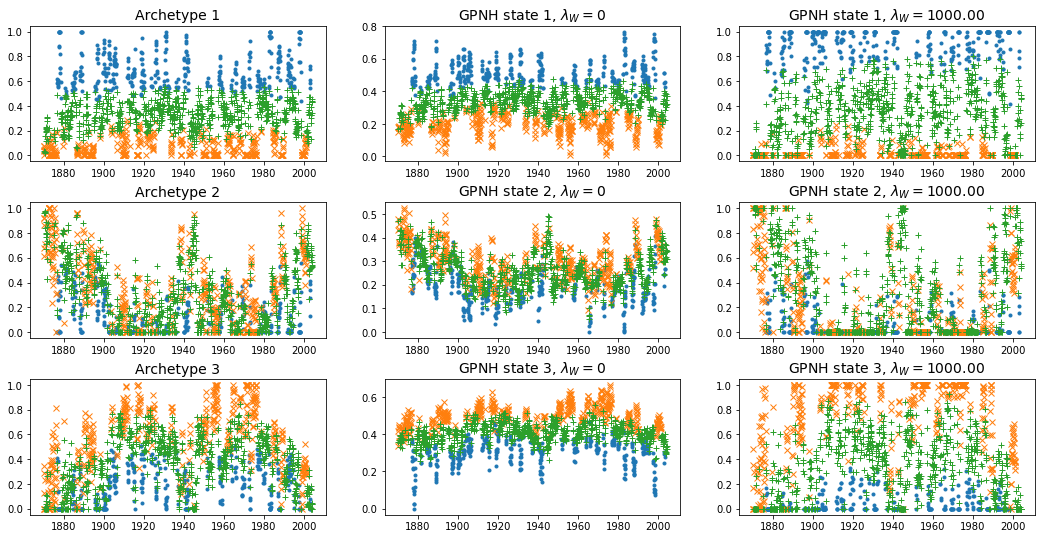

In [13]:
n_components = 3
lambda_W = 1e3

aa_output_file = get_aa_output_filename(SST_ANOM_INPUT_FILE, LAT_WEIGHTS, n_components, DELTA, N_INIT)
kmeans_output_file = get_kmeans_output_filename(SST_ANOM_INPUT_FILE, LAT_WEIGHTS, n_components, N_INIT, REFERENCE)
gpnh_no_reg_output_file = get_gpnh_output_filename(SST_ANOM_INPUT_FILE, LAT_WEIGHTS, n_components, 0, N_INIT)
gpnh_reg_output_file = get_gpnh_output_filename(SST_ANOM_INPUT_FILE, LAT_WEIGHTS, n_components, lambda_W, N_INIT)

aa_ds = xr.open_dataset(aa_output_file)
gpnh_no_reg_ds = xr.open_dataset(gpnh_no_reg_output_file)
gpnh_reg_ds = xr.open_dataset(gpnh_reg_output_file)
kmeans_ds = xr.open_dataset(kmeans_output_file)

eofs_reference_file = os.path.join(RESULTS_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.pca.{}.k{:d}.nc'.format(
        BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS, n_components))

aa_ds = sort_states(aa_ds, eofs_reference_file, variable_name='archetypes')
gpnh_no_reg_ds = sort_states(gpnh_no_reg_ds, eofs_reference_file, variable_name='dictionary')
gpnh_reg_ds = sort_states(gpnh_reg_ds, eofs_reference_file, variable_name='dictionary')
kmeans_ds = sort_states(kmeans_ds, eofs_reference_file, variable_name='dictionary')

nrows = n_components
ncols = 3

fig = plt.figure(constrained_layout=False, figsize=(6 * ncols, 3 * nrows))

gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig,
                       wspace=0.2, hspace=0.3)

row_index = 0
for component in range(n_components):

    cluster_labels = kmeans_ds['weights'].values
    
    gpnh_no_reg_weights = gpnh_no_reg_ds['weights'].sel(component=component)
    gpnh_reg_weights = gpnh_reg_ds['weights'].sel(component=component)
    aa_weights = aa_ds['weights'].sel(component=component)
    
    col_index = 0
    ax = fig.add_subplot(gs[row_index, col_index])
    markers = itertools.cycle(('.', 'x', '+', 's', 'o'))
    for k in range(n_components):

        marker = next(markers)
        mask = cluster_labels[k] != 0

        ax.plot(aa_ds[TIME_NAME].values[mask], aa_weights[mask], marker=marker, ls='none')
    
    ax.set_title('Archetype {}'.format(component + 1), fontsize=14)

    col_index = 1
    ax = fig.add_subplot(gs[row_index, col_index])
    markers = itertools.cycle(('.', 'x', '+', 's', 'o'))
    for k in range(n_components):

        marker = next(markers)
        mask = cluster_labels[k] != 0

        ax.plot(gpnh_no_reg_ds[TIME_NAME].values[mask], gpnh_no_reg_weights[mask], marker=marker, ls='none')
    
    ax.set_title('GPNH state {}, $\lambda_W = 0$'.format(component + 1), fontsize=14)

    col_index = 2
    ax = fig.add_subplot(gs[row_index, col_index])
    markers = itertools.cycle(('.', 'x', '+', 's', 'o'))
    for k in range(n_components):

        marker = next(markers)
        mask = cluster_labels[k] != 0

        ax.plot(gpnh_reg_ds[TIME_NAME].values[mask], gpnh_reg_weights[mask], marker=marker, ls='none')
    
    ax.set_title('GPNH state {}, $\lambda_W = {:.2f}$'.format(component + 1, lambda_W), fontsize=14)

    row_index += 1
        
plt.show()

plt.close()

aa_ds.close()
gpnh_no_reg_ds.close()
gpnh_reg_ds.close()

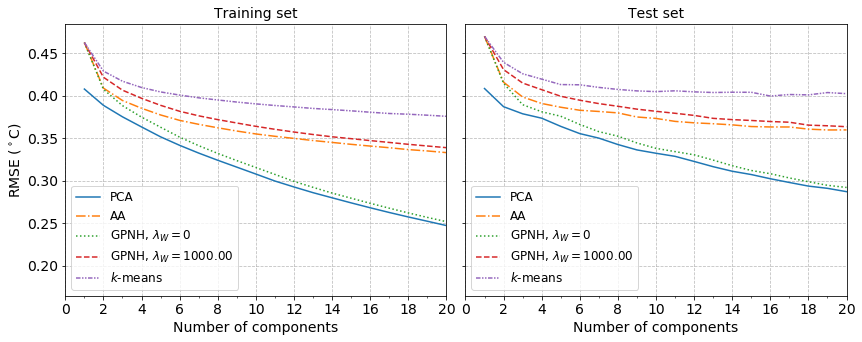

In [14]:
lambda_W = 1000

pca_cost_file = 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.pca.{}.cost.csv'.format(
    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS, N_INIT)
pca_cost_file = os.path.join(CSV_DIR, pca_cost_file)

pca_cost_data = np.genfromtxt(pca_cost_file, delimiter=',', names=True)
pca_max_components = np.max(pca_cost_data['n_components'])

aa_cost_file = 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.aa.{}.delta{:5.3e}.n_init{:d}.cost.csv'.format(
    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS, DELTA, N_INIT)
aa_cost_file = os.path.join(CSV_DIR, aa_cost_file)

aa_cost_data = np.genfromtxt(aa_cost_file, delimiter=',', names=True)
aa_max_components = np.max(aa_cost_data['n_components'])

gpnh_no_reg_cost_file = 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.gpnh.{}.lambda_W{:5.3e}.n_init{:d}.cost.csv'.format(
    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS, 0, N_INIT)
gpnh_no_reg_cost_file = os.path.join(CSV_DIR, gpnh_no_reg_cost_file)

gpnh_no_reg_cost_data = np.genfromtxt(gpnh_no_reg_cost_file, delimiter=',', names=True)
gpnh_no_reg_max_components = np.max(gpnh_no_reg_cost_data['n_components'])

gpnh_reg_cost_file = 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.gpnh.{}.lambda_W{:5.3e}.n_init{:d}.cost.csv'.format(
    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS, lambda_W, N_INIT)
gpnh_reg_cost_file = os.path.join(CSV_DIR, gpnh_reg_cost_file)

gpnh_reg_cost_data = np.genfromtxt(gpnh_reg_cost_file, delimiter=',', names=True)
gpnh_reg_max_components = np.max(gpnh_reg_cost_data['n_components'])

kmeans_cost_file = 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.kmeans.{}.n_init{:d}.{}_gap.cost.csv'.format(
    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS, N_INIT, REFERENCE)
kmeans_cost_file = os.path.join(CSV_DIR, kmeans_cost_file)

kmeans_cost_data = np.genfromtxt(kmeans_cost_file, delimiter=',', names=True)
kmeans_max_components = np.max(kmeans_cost_data['n_components'])

max_n_components = min(pca_max_components, aa_max_components, gpnh_no_reg_max_components,
                       gpnh_reg_max_components, kmeans_max_components)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), squeeze=False, sharey=True)
fig.subplots_adjust(wspace=0.05)

linestyles = itertools.cycle(('-', '-.', ':', '--', (0, (3, 1, 1, 1, 1, 1))))

ls = next(linestyles)
ax[0, 0].plot(pca_cost_data['n_components'], pca_cost_data['training_set_rmse'], ls=ls, label='PCA')
ax[0, 1].plot(pca_cost_data['n_components'], pca_cost_data['test_set_rmse'], ls=ls, label='PCA')

ls = next(linestyles)
ax[0, 0].plot(aa_cost_data['n_components'], aa_cost_data['training_set_rmse'], ls=ls, label='AA')
ax[0, 1].plot(aa_cost_data['n_components'], aa_cost_data['test_set_rmse'], ls=ls, label='AA')

ls = next(linestyles)
ax[0, 0].plot(gpnh_no_reg_cost_data['n_components'], gpnh_no_reg_cost_data['training_set_rmse'], ls=ls,
              label='GPNH, $\lambda_W = 0$')
ax[0, 1].plot(gpnh_no_reg_cost_data['n_components'], gpnh_no_reg_cost_data['test_set_rmse'], ls=ls,
              label='GPNH, $\lambda_W = 0$')

ls = next(linestyles)
ax[0, 0].plot(gpnh_reg_cost_data['n_components'], gpnh_reg_cost_data['training_set_rmse'], ls=ls,
              label='GPNH, $\lambda_W = {:.2f}$'.format(lambda_W))
ax[0, 1].plot(gpnh_reg_cost_data['n_components'], gpnh_reg_cost_data['test_set_rmse'], ls=ls,
              label='GPNH, $\lambda_W = {:.2f}$'.format(lambda_W))

ls = next(linestyles)
ax[0, 0].plot(kmeans_cost_data['n_components'], kmeans_cost_data['training_set_rmse'], ls=ls,
              label='$k$-means')
ax[0, 1].plot(kmeans_cost_data['n_components'], kmeans_cost_data['test_set_rmse'], ls=ls,
              label='$k$-means')

ax[0, 0].grid(ls='--', color='gray', alpha=0.5)
ax[0, 0].legend(fontsize=12)

ax[0, 1].grid(ls='--', color='gray', alpha=0.5)
ax[0, 1].legend(fontsize=12)

ax[0, 0].set_xlabel('Number of components', fontsize=14)
ax[0, 0].set_xlim(0, max_n_components)
ax[0, 1].set_xlabel('Number of components', fontsize=14)
ax[0, 1].set_xlim(0, max_n_components)

ax[0, 0].set_ylabel('RMSE ($^\circ$C)', fontsize=14)

ax[0, 0].set_title('Training set', fontsize=14)
ax[0, 1].set_title('Test set', fontsize=14)

ax[0, 0].xaxis.set_major_locator(ticker.MultipleLocator(2))
ax[0, 0].xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax[0, 0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax[0, 0].tick_params(labelsize=14)

ax[0, 1].xaxis.set_major_locator(ticker.MultipleLocator(2))
ax[0, 1].xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax[0, 1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax[0, 1].tick_params(labelsize=14)

output_file = 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.combined.{}.rmse.pdf'.format(
    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS)
output_file = os.path.join(PLOTS_DIR, output_file)

plt.savefig(output_file, bbox_inches='tight')

plt.show()

plt.close()